# **Fruit Inspection**
# Student: Andrea Rossolini

#Id: 0000954735

To run all the cells NumPy version 1.21.5+ is needed

In [ ]:
!pip install numpy --upgrade

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import scipy.spatial as sc
%matplotlib inline

## Load images
The images available for this project are devided for first and second task. In both groups, the pictures are acquired with a Near Infra-red camera and a color camera, with a parallax effect.

* The first task has three couples of images
* The second task has two couples of images

In [ ]:
img_path = 'Fruit_Inspection/images/'

# First task
## NIR images
t1_img1_nir = cv2.imread(img_path + "first task/C0_000001.png", cv2.IMREAD_GRAYSCALE)
t1_img2_nir = cv2.imread(img_path + "first task/C0_000002.png", cv2.IMREAD_GRAYSCALE)
t1_img3_nir = cv2.imread(img_path + "first task/C0_000003.png", cv2.IMREAD_GRAYSCALE)
t1_imgs_nir = np.array([t1_img1_nir, t1_img2_nir, t1_img3_nir], dtype=object)

## Colored images
t1_img1_c = cv2.cvtColor(cv2.imread(img_path + "first task/C1_000001.png", cv2.IMREAD_COLOR),cv2.COLOR_BGR2RGB) 
t1_img2_c = cv2.cvtColor(cv2.imread(img_path + "first task/C1_000002.png", cv2.IMREAD_COLOR),cv2.COLOR_BGR2RGB) 
t1_img3_c = cv2.cvtColor(cv2.imread(img_path + "first task/C1_000003.png", cv2.IMREAD_COLOR),cv2.COLOR_BGR2RGB) 
t1_imgs_c = np.array([t1_img1_c, t1_img2_c, t1_img3_c], dtype=object)

# Second task
## NIR images
t2_img1_nir = cv2.imread(img_path + "second task/C0_000004.png", cv2.IMREAD_GRAYSCALE)
t2_img2_nir = cv2.imread(img_path + "second task/C0_000005.png", cv2.IMREAD_GRAYSCALE)
t2_imgs_nir = np.array([t2_img1_nir, t2_img2_nir], dtype=object)

## Colored images
t2_img1_c = cv2.cvtColor(cv2.imread(img_path + "second task/C1_000004.png", cv2.IMREAD_COLOR),cv2.COLOR_BGR2RGB) 
t2_img2_c = cv2.cvtColor(cv2.imread(img_path + "second task/C1_000005.png", cv2.IMREAD_COLOR),cv2.COLOR_BGR2RGB)
t2_imgs_c = np.array([t2_img1_c, t2_img2_c], dtype=object)

##Utility functions

The following functions are used to plot figures, histograms and the defects found on the fruits.


In [ ]:
def plot_figures(img_list, title_img = 'fig -', cmap='viridis', figsize=(10,10)):
  plt.figure(figsize=figsize)
  for num, img in enumerate(img_list, start = 1):
    plt.subplot(1,len(img_list), num)
    plt.imshow(img, cmap=cmap, vmin=0, vmax=255)
    plt.title(title_img + " " + str(num), fontsize = 15)
  plt.show()

def plot_hist(img_list, title_img = 'Histogram img -', figsize = (20,10), bins = 50):
  plt.figure(figsize=figsize)
  for num, img in enumerate(img_list, start = 1):
    plt.subplot(1,len(img_list), num)
    plt.hist(img.flatten(), bins=bins)
    plt.grid()
    plt.title(title_img + " " + str(num), fontsize = 15)
  plt.show()

def draw_defects(img_list, defect_list, isRGB = True, r_val = 255, g_val = 0, b_val = 0):
  res = []
  
  for img, defects in zip(img_list, defect_list):
    img_cpy = img.copy() if isRGB else cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    h, w = img.shape[:2]

    for py in range(h):
        for px in range(w):
            if(defects[py][px]):
              img_cpy[py][px][0] = r_val
              img_cpy[py][px][1] = g_val
              img_cpy[py][px][2] = b_val

    res.append(img_cpy)
  return res

### First task pictures

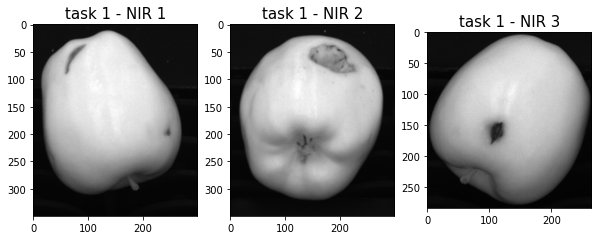

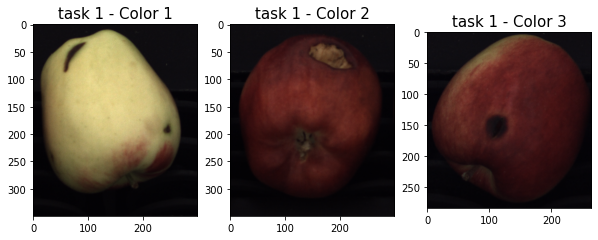

In [ ]:
plot_figures(t1_imgs_nir, "task 1 - NIR", cmap="gray")
plot_figures(t1_imgs_c, "task 1 - Color")

 ### Second task pictures

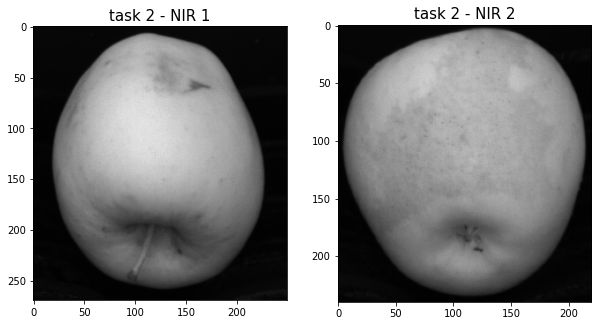

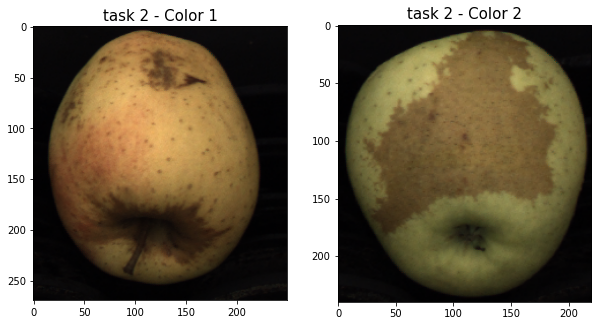

In [ ]:
plot_figures(t2_imgs_nir, "task 2 - NIR", cmap="gray")
plot_figures(t2_imgs_c, "task 2 - Color")

# 1. **First task**: fruit segmentation and defect detection


* *Outline the fruit by generating a binary mask*

**HINT**: *first threshold the whole image in order to remove the background, but keeping intact the fruit borders; then fill the holes inside the fruit blob using a flood-fill approach. The image pair has little parallax, so a mask might be computed on one image and then applied on the other one.*

* *Search for the defects on each fruit*

**HINT**: *the defects have strong edges, so edge extraction algorithm should help. Also, they usually exhibit a far darker color with respect to the neighboring areas of the fruit.*

## 1.1. Fruit segmentation


The first step is to outline the fruit by creating a binary mask. The following cell shows the histograms of the three NIR pictures and then an analysis of them is carried out.

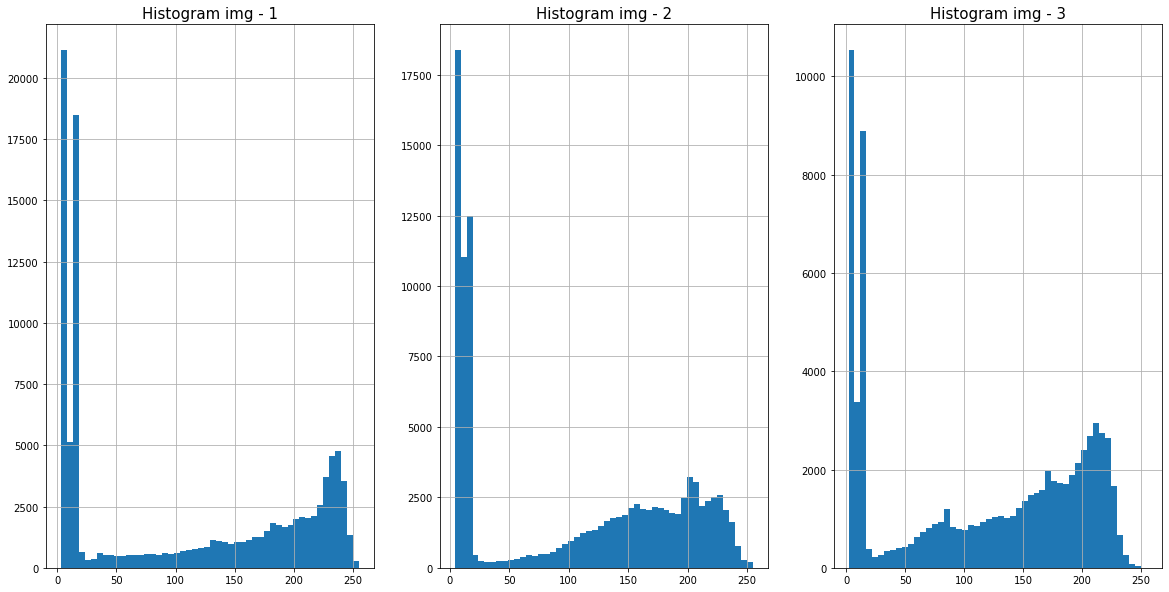

In [ ]:
plot_hist(t1_imgs_nir)

### 1.1.1. Background removing 
* The three histograms generated has some peaks. These peaks represent the background of the picture, while the other grayish pixels are spread over the histogram. Considering this task is dealing with three different pictures, and we want to generalize the algorithm as most as we can, we need to find a way to threshold each picture differently.


* To achieve this result, it is possible to compute the **Otsu's algorithm**. The idea behind this algorithm is to segment the image into two maximally homogeneous regions. From this situation, find the optimal threshold that minimizes the gray-level range. This process finds the within-group Variance, which measures the spread of the region intensities after the binarization. 

In conclusion, it is not needed to specify a specific threshold, since with this approach the algorihm finds the specific best threshold and proceeds with the binarization and preserves the apple's borders.

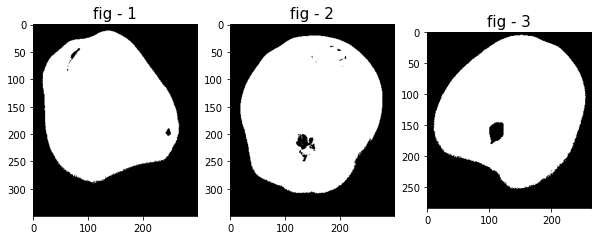

In [ ]:
# Thresholding with Otsu's method
thresh = 0 # this threshold is chosen automatically by the algorithm
maxValue = 255

dst_imgs = [
       cv2.threshold(img, thresh, maxValue, cv2.THRESH_OTSU)[1]
       for img in t1_imgs_nir     
]

plot_figures(dst_imgs, cmap="gray")

### 1.1.2. Flood-fill approach
To fill the holes inside the fruit BLOb, it can be used a flood-fill approach. The image pair has little parallax, so a mask might be computed on one image and then applied on the other one.

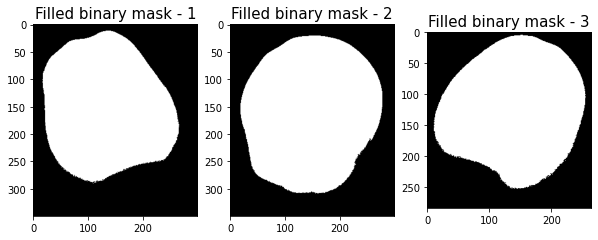

In [ ]:
masks_binary = []
for img in dst_imgs :
  img_copy = img.copy()
  h, w = img.shape
  flooding_mask = np.zeros((h+2, w+2), np.uint8)

  cv2.floodFill(img_copy,
                flooding_mask,
                seedPoint = (0,0),
                newVal = 255);
  inverted_img = np.invert(img_copy > 0) * 255
  msk = img | inverted_img
  masks_binary.append(np.array(msk, dtype=np.uint8))
  
plot_figures(masks_binary, title_img="Filled binary mask -", cmap="gray")

Using these masks, we can cut out the background from the original fruit pictures

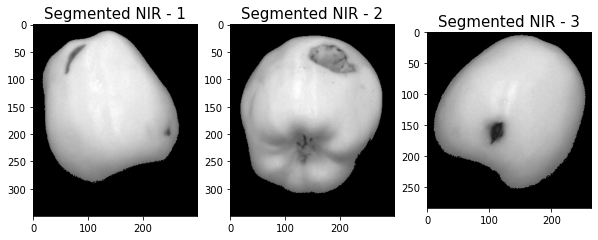

In [ ]:
masks_inr = []
for mask, img_nir in zip(masks_binary, t1_imgs_nir):
  final_mask = mask/255*img_nir
  masks_inr.append(np.array(final_mask, dtype=np.uint8))

plot_figures(masks_inr, title_img="Segmented NIR -", cmap="gray")

## 1.2. Defects detection
The images obtained so far show a homogenous background and slightly cropped apples, but nothing that prevents us from continuing.
The following steps have been followed to perform the defect detection:

* **Edge detection**: To higlight the difects we can use a *Canny Edge Detection* algorithm. CED function has two parameters (*high-threshold* and *low-threshold*) which determine the **hysteresis process** of thresholding and which have to be carefully tuned.

* **Erosion**: This technique is usually used to correct segmentation errors or separate wronlgy connected objects. $A\ominus B = \{c\in E^2:c+b \in A, \forall\ b \in B \}$.
Where $A$ is the set of foreground pixels and $B$ is the structuring element (kernel). It is possible to perform different iteration with the same kernel to obtain better results. The erosion process reduce the dimension of the binary mask, in this way it possible to use the mask to hilight the edges that are not in the apples borders, thus the edges of the defects.

* **Apply mask**: The mask is obtained by a "bitwise and" between the image, after the canny's edge detection, and the binary image eroded.
In this way, we obtain a mask with just the defect detected on the apple.

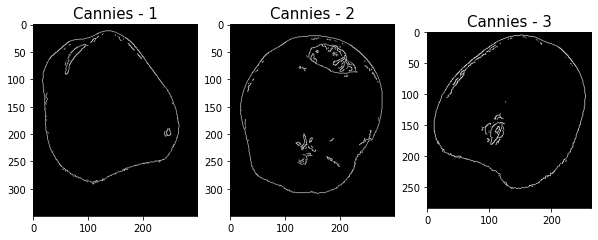

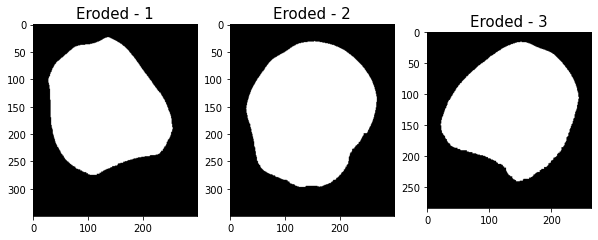

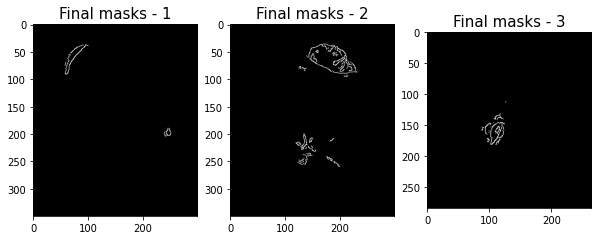

In [ ]:
kernel_size = (5,5)
iterations = 5
thresh = 0
maxValue = 1

cannies = []
defect_list = []
eroded = []
for mask_inr, mask_bianry in zip(masks_inr,masks_binary):
  h_th, _ = cv2.threshold(mask_inr, thresh, maxValue, cv2.THRESH_OTSU)
  
  # Canny's edge detector
  img_canny = cv2.Canny(mask_inr, h_th / 2, h_th)
  cannies.append(img_canny)

  # Erosion
  kernel = np.ones(kernel_size, np.uint8)
  eroded_mask = cv2.erode(mask_bianry, kernel, iterations = iterations)
  eroded.append(eroded_mask)

  # Mask creation
  defects = eroded_mask & img_canny
  defect_list.append(defects)

plot_figures(cannies, cmap='gray', title_img='Cannies -')
plot_figures(eroded, cmap='gray', title_img='Eroded -')
plot_figures(defect_list, cmap='gray', title_img='Final masks -')

## 1.3. First task result

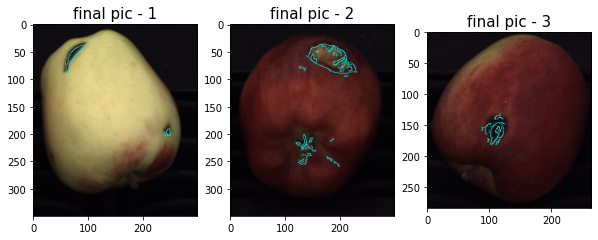

In [ ]:
defect_detected = draw_defects(t1_imgs_c, defect_list, r_val = 0, g_val= 255, b_val = 255)
plot_figures(defect_detected, title_img = 'final pic -')

As shown in the images, the algorithm worked perfectly, except for photo number 2, where the bottom of the apple is identified as a defect. 

# 2. **Second task**: Russet detection

"*Images in folder “second task” show two apples with an unwanted reddish-brown area.*

*Students should identify the russet or at least some part of it with no false positive areas (if possible), in order to correctly classify the two fruits.*


*HINT: Find a suitable (Mahalanobis) color distance. Other color spaces, e.g. HSV, HSL, LUV, should be tried*"

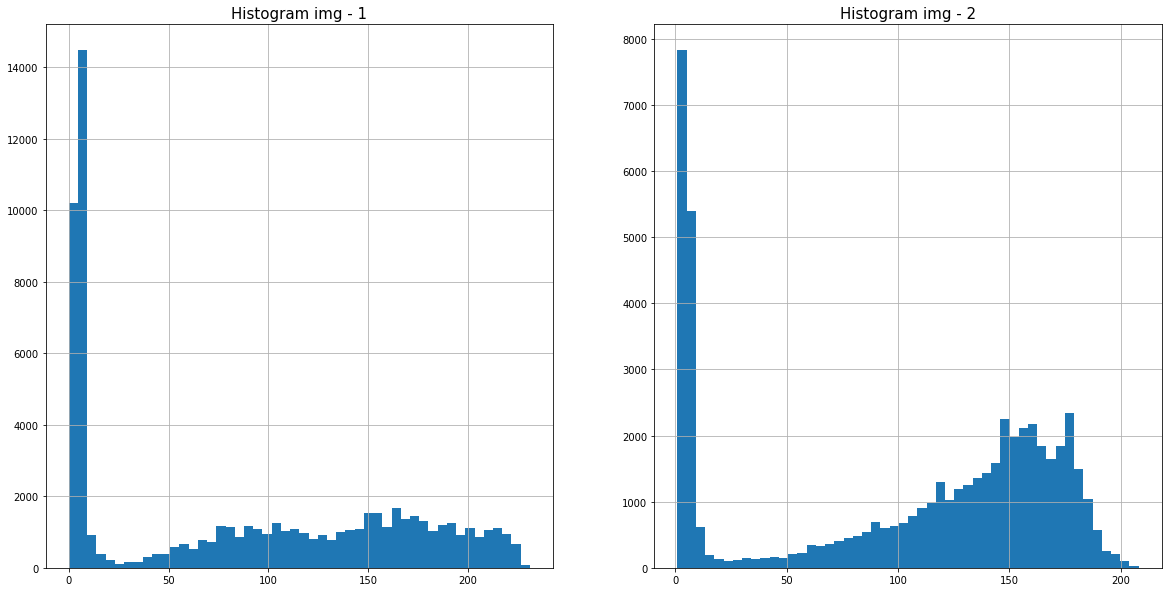

In [ ]:
plot_hist(t2_imgs_nir)

From the histograms we can already see how the second image contains an important irregularities.

## 2.0. Utility functions
In the follwing cell there are the function used just in the second task.

- **dominant_hist**: computes the histogram main value wrt to a picture with or without the backgroung 
- **create_binary_mask**: creates a binary maskof a given picture, following the process explained in the first task (threshold, floodfill, smoothing, erosion)
- **remove_background**: uses the binary mask of a picture to remove the background from the original picture
- **find_russet**: Using mahalanobis distance in a LUV color space, detects the russet from the apples.

In [ ]:
def dominant_hist(img, isBackground = True):
  # computes the histogram main value wrt to a picture with or without the backgroung
  if isBackground :
    avg_val = np.mean(img.flatten())
  else :
    img_bool = img.flatten().astype(bool) # from 8int to bool 0 -> False, 1 -> True
    avg_val = np.mean(img.flatten(), where = img_bool)
  return avg_val

def create_binary_mask(image_grey, thresh=25, kernel = (5,5), iterations = 5):
  _, th = cv2.threshold(image_grey, thresh, 255, cv2.THRESH_BINARY)

  # Floodfill and invert
  th_copy = th.copy()
  h, w = th.shape[:2]
  mask = np.zeros((h+2, w+2), np.uint8)
  cv2.floodFill(th_copy, mask, (0,0), 255)
  th_inv = cv2.bitwise_not(th_copy)
  im_out = th | th_inv

  #Smoothing the image and removing the borders
  mask = cv2.medianBlur(im_out, 3)
  kernel = np.ones(kernel, np.uint8) 
  mask = cv2.erode(mask, kernel, iterations = iterations)
  return mask

def remove_background(image_color, binary_mask):
  image_no_bg = image_color.copy()
  for i in range(3):
    image_no_bg[:,:,i] =  binary_mask & image_no_bg[:, :, i]

  return image_no_bg

def find_russet(image, binary_mask, threshold, very_russet = False, metric = 'mahalanobis', color_space = cv2.COLOR_RGB2LUV):
  image = cv2.medianBlur(image, 3)
  image_cs = cv2.cvtColor(image, color_space) # from RGB to new color space

  image_UV = image_cs[:, :, 1:3] # This works with default color space (LUV)
  h, w = image_cs.shape[:2]
  image_UV = image_UV.reshape(h * w, 2)
  cov, mean = cv2.calcCovarMatrix(image_UV, None, cv2.COVAR_NORMAL | cv2.COVAR_ROWS | cv2.COVAR_SCALE)
  cov_inv = cv2.invert(cov, cv2.DECOMP_SVD)

  russet = np.zeros((h, w))

  # find the true mean value in the color space
  mask = np.array(binary_mask,dtype=bool)
  mean[0][0] = np.mean(image_cs[:, :, 1], where = mask)
  mean[0][1] = np.mean(image_cs[:, :, 1], where = mask)
  russet_sample = mean / h

  for i in range(h):
    for j in range(w):
      pixel = np.array(image_cs[i][j])[1:3].reshape(1, 2)
      if binary_mask[i][j] != 0: #calculate distance only on apple pixels
        distance = sc.distance.cdist(pixel, russet_sample, metric, VI=cov_inv[1])
        # Add 'very_russet' parameter to separate images with a wide part of russet pixels
        if very_russet and (distance > threshold):
          russet[i][j] = 255
        elif not very_russet and (distance < threshold):
          russet[i][j] = 255
  return russet.astype('uint8')

## 2.1. Process used to solve the task
To deal with this task, we can proceed as follows:

* **Create a binary mask**: As it is shown in the first task, we can generate a binary mask of the apple:
 1. Picture thresholding.
 2. Floodfill algorithm, to fill the gaps.
 3. Erosion of the obtained result.
* **Remove the background**.
* **Detect the russet**: The russet detection is applied as follows:
 1. Compute Mahalanobis distance to separate the russet from the good apple (the background is already been removed).
 2. If the dimension of the russet is above a given threshold (e.g.: image #2), it is assumed that the biggest set of pixels belongs to the apple's russet area. Otherwise, to the apple's good area.

In [ ]:
metric_ths = [9, 18.3]
iterations = [8,3]

russets_found, imgs_masked = [], []
for t2_img_c, t2_img_nir, metric_th, iter in zip(t2_imgs_c, t2_imgs_nir, metric_ths, iterations):
  # Create binary mask
  binary_mask = create_binary_mask(t2_img_nir, iterations = iter)
  # Remove the background
  image_masked = remove_background(t2_img_c, binary_mask)
  imgs_masked.append(image_masked)

  # Detect the russet
  img_no_bg_nir = cv2.cvtColor(image_masked, cv2.COLOR_RGB2GRAY)
  very_russet = True if \
    dominant_hist(t2_img_nir) > dominant_hist(img_no_bg_nir, isBackground=False)\
    else False
  
  russet = find_russet(image_masked, binary_mask, metric_th, very_russet=very_russet)
  russets_found.append(russet)

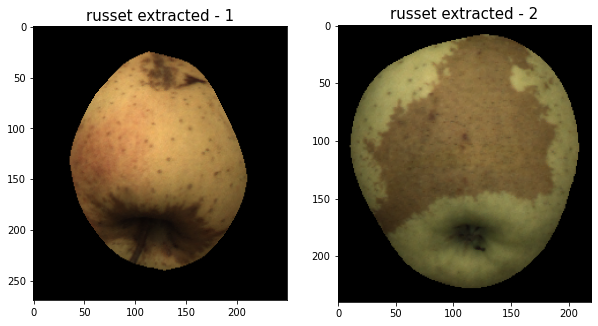

In [ ]:
plot_figures(imgs_masked, title_img = 'russet extracted -', cmap='gray')

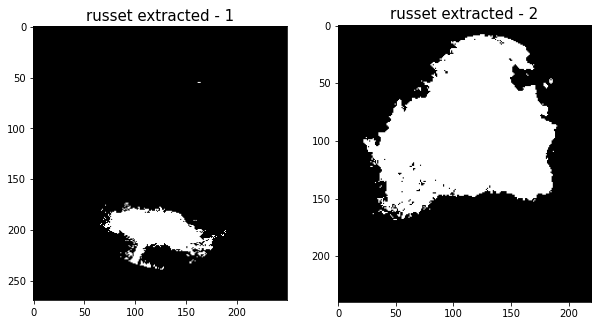

In [ ]:
plot_figures(russets_found, title_img = 'russet extracted -', cmap='gray')

## 2.2. Second task result

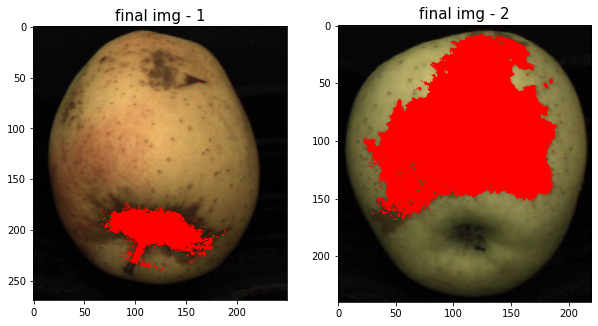

In [ ]:
defect_detected = draw_defects(t2_imgs_c, russets_found, r_val = 255, g_val= 0, b_val = 0)
plot_figures(defect_detected, title_img = 'final img -')

As it is possible to see, the russets identified are almost perfect in the right picture, while in the left one the algorithm misses a little spot. Tuning the parameters it is easy to detect the missed spot, but the algorithm will find other fasle positives.

### Experiments with different colour spaces
The solution proposed uses the LUV color space, since it is the one that achieved better results. However, other color spaces have been tested (HSV, HSL). As we can expect, with different color spaces, we need to change some parameters. First of all, the threshold used to compute the Mahalanobis distance. As well as the iteration used to erode the pictures. For example, using the HSV color space, it was more difficult to extract the russet from the first picture, becuase it tends to be confused with the left side of the apple (the one more in the shadow).